### 목표 : 당뇨병 예측 모델 구현
- 데이터 : scikit-learn dataset
- 피쳐 : 10
- 타겟 : 정수값

1. load_diabetes() : 정규화된 데이터셋 불러오기

In [2]:
# 0. 모듈 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# 1. 데이터 불러오기
features_df, target_sr = load_diabetes(return_X_y=True, as_frame=True)
features_df, target_sr

(          age       sex       bmi        bp        s1        s2        s3  \
 0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
 1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
 2    0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
 3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
 4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
 ..        ...       ...       ...       ...       ...       ...       ...   
 437  0.041708  0.050680  0.019662  0.059744 -0.005697 -0.002566 -0.028674   
 438 -0.005515  0.050680 -0.015906 -0.067642  0.049341  0.079165 -0.028674   
 439  0.041708  0.050680 -0.015906  0.017293 -0.037344 -0.013840 -0.024993   
 440 -0.045472 -0.044642  0.039062  0.001215  0.016318  0.015283 -0.028674   
 441 -0.045472 -0.044642 -0.073030 -0.081413  0.083740  0.027809  0.173816   
 
            s4        s5        s6  
 0   -0.002592  0.019907 

2. 데이터 전처리 : 결측값, 중복값, 이상치 확인 -> 이상 없음

In [3]:
# 2. 데이터 전처리
features_df.info()  # 모두 float, 정규화, 결측값 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


In [4]:
# 2-1. 중복값 확인
features_df.duplicated().sum()  # 중복값 없음

0

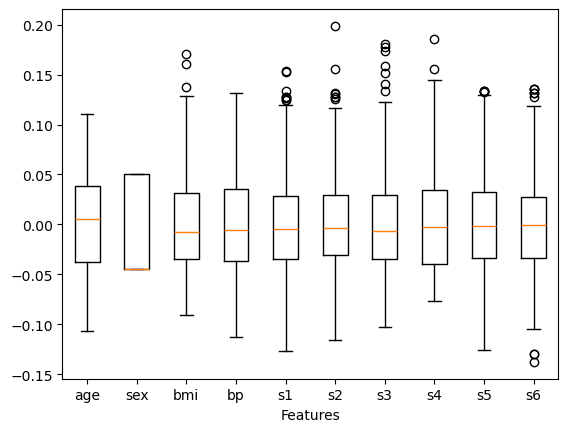

In [5]:
# 2-2. 이상치 확인
plt.boxplot(features_df)
plt.xlabel('Features')
plt.xticks(range(1, 11), features_df.columns)
plt.show()  # bmi, s1, s2, s3, s4, s5, s6에서 많은 이상치를 보임

2-3. 이상치 제거 : bmi, s5 먼저 찾고 생각난 부분, 우선 두 피처에만 적용 -> 점수는 더 감소
                   ToDo) 전체 데이터에도 적용하면 상관 계수가 달라질까

In [6]:

# 2-3. 이상치 제거
# 1) boxplot에서 이상치를 제거하는 함수
def remove_outliers(data, threshold=1.5):
    """
    이상치 제거 함수
    :param data: 이상치를 제거할 데이터 (numpy array 형태)
    :param threshold: 정상 범주의 IQR 배수 (기본 1.5)
    :return: 이상치 제거 데이터
    """
    # 상위 3 분위와 하위 3 분위의 값 구하기
    Q1 = np.percentile(data.tolist(), 25)
    Q3 = np.percentile(data.tolist(), 75)
    IQR = Q3 - Q1
    
    # 이상치 제거
    mask = (data < Q1 - threshold * IQR) | (data > Q3 + threshold * IQR)
    filtered_data = data[mask]
    return filtered_data

# 2) 이상치 확인
remove_outliers(features_df.bmi), remove_outliers(features_df.s5)

(256    0.160855
 366    0.137143
 367    0.170555
 Name: bmi, dtype: float64,
 23     0.133597
 169    0.133597
 322    0.133397
 353    0.132376
 Name: s5, dtype: float64)

In [7]:
# 3) bmi, s5 이상치 제거
remove_index = remove_outliers(features_df.bmi).index.tolist() + remove_outliers(features_df.s5).index.tolist()
print(remove_index)
remove_feature = features_df.drop(remove_index)
remove_target = target_sr.drop(remove_index)
features_df.shape, target_sr.shape, remove_feature.shape, remove_target.shape
# remove 배제 이유: 맨 아래 기술

[256, 366, 367, 23, 169, 322, 353]


((442, 10), (442,), (435, 10), (435,))

In [8]:
# 이상치 제거한 상관 계수
corr_df = pd.concat([remove_feature, remove_target], axis=1)
corr_df.corr().abs().sort_values('target', ascending=False)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
target,0.194932,0.036903,0.574823,0.449506,0.215694,0.180674,0.385981,0.423731,0.575893,0.375032,1.000000
s5,0.286796,0.151388,0.457699,0.399436,0.509800,0.344229,0.387384,0.602651,1.000000,0.451860,0.575893
bmi,0.203580,0.073584,1.000000,0.416603,0.260150,0.271497,0.360118,0.408489,0.457699,0.383985,0.574823
bp,0.331357,0.238087,0.416603,1.000000,0.242578,0.190699,0.173908,0.252653,0.399436,0.388973,0.449506
s4,0.209861,0.331368,0.408489,0.252653,0.542130,0.684504,0.734327,1.000000,0.602651,0.402672,0.423731
s3,0.075838,0.378771,0.360118,0.173908,0.059632,0.204450,1.000000,0.734327,0.387384,0.260602,0.385981
s6,0.302941,0.199028,0.383985,0.388973,0.322951,0.303352,0.260602,0.402672,0.451860,1.000000,0.375032
s1,0.267296,0.034819,0.260150,0.242578,1.000000,0.907633,0.059632,0.542130,0.509800,0.322951,0.215694
age,1.000000,0.170637,0.203580,0.331357,0.267296,0.224652,0.075838,0.209861,0.286796,0.302941,0.194932
s2,0.224652,0.143430,0.271497,0.190699,0.907633,1.000000,0.204450,0.684504,0.344229,0.303352,0.180674


2-3. 상관 계수 확인 : 

In [9]:
# 2-3. 상관계수 확인
# 1) 타겟과 합치기
corr_df = pd.concat([features_df, target_sr], axis=1)
corr_df.corr().abs().sort_values('target', ascending=False) 
# bmi와 s5가 각각 0.576, 0.575으로 높은 상관 관계를 보임

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
target,0.187889,0.043062,0.586450,0.441482,0.212022,0.174054,0.394789,0.430453,0.565883,0.382483,1.000000
bmi,0.185085,0.088161,1.000000,0.395411,0.249777,0.261170,0.366811,0.413807,0.446157,0.388680,0.586450
s5,0.270774,0.149916,0.446157,0.393480,0.515503,0.318357,0.398577,0.617859,1.000000,0.464669,0.565883
bp,0.335428,0.241010,0.395411,1.000000,0.242464,0.185548,0.178762,0.257650,0.393480,0.390430,0.441482
s4,0.203841,0.332115,0.413807,0.257650,0.542207,0.659817,0.738493,1.000000,0.617859,0.417212,0.430453
s3,0.075181,0.379090,0.366811,0.178762,0.051519,0.196455,1.000000,0.738493,0.398577,0.273697,0.394789
s6,0.301731,0.208133,0.388680,0.390430,0.325717,0.290600,0.273697,0.417212,0.464669,1.000000,0.382483
s1,0.260061,0.035277,0.249777,0.242464,1.000000,0.896663,0.051519,0.542207,0.515503,0.325717,0.212022
age,1.000000,0.173737,0.185085,0.335428,0.260061,0.219243,0.075181,0.203841,0.270774,0.301731,0.187889
s2,0.219243,0.142637,0.261170,0.185548,0.896663,1.000000,0.196455,0.659817,0.318357,0.290600,0.174054


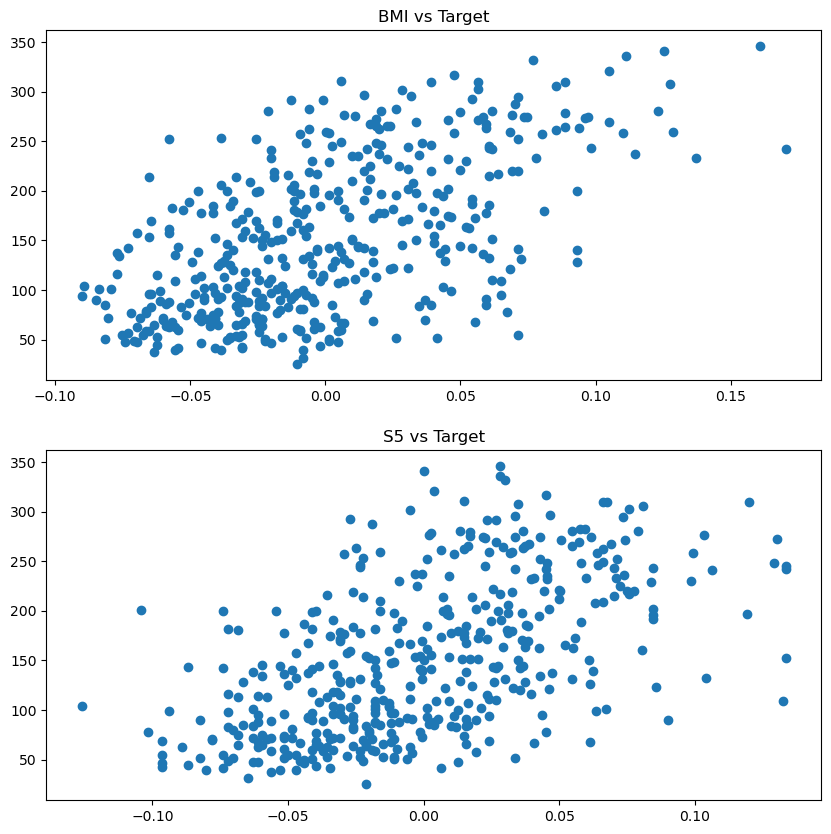

In [10]:
# 2-4. feature 시각화
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.scatter(features_df.bmi, target_sr)
plt.title('BMI vs Target')

plt.subplot(2, 1, 2)
plt.scatter(features_df.s5, target_sr)
plt.title('S5 vs Target')
plt.show()  # 우상향의 경향성이 보인다.

In [11]:
# 3. KNN 모델 적용
# 3-1. 학습 데이터 분리
feature = features_df[['bmi', 's5']]
X_train, X_test, y_train, y_test = train_test_split(feature, target_sr, test_size=0.3, random_state=42)

# 3-2. 모델 생성
knn = KNeighborsRegressor()     # 주영: 연속형엔 회귀!
knn.fit(X_train, y_train)
knn.score(X_test, y_test)
y_pred = knn.predict(X_test)
print('knn score:',knn.score(X_test, y_test))

knn score: 0.4201000881070408


In [12]:
# 4. 모델 평가 : RMSE, R2, MAE
# 1) R2
r2 = r2_score(y_test, y_pred)
print('R2 :', r2)
# 2) RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE :', rmse)
# 3) MAE
mae = mean_absolute_error(y_test, y_pred)
print('MAE :', mae)

print(f"""{'-'*50}
n_neighbors의 값을 지정하지 않은 기본(=5)값으로 KNN 모델을 생성했을 때의 결과,
test score : {knn.score(X_test, y_test):.4f}, R2 : {r2:.4f} 으로 나옴.""")

R2 : 0.4201000881070408
RMSE : 55.95067645246768
MAE : 44.06015037593985
--------------------------------------------------
n_neighbors의 값을 지정하지 않은 기본(=5)값으로 KNN 모델을 생성했을 때의 결과,
test score : 0.4201, R2 : 0.4201 으로 나옴.


최대 test score : 0.5139764780942386
해당 n_neighbors 값 : 52


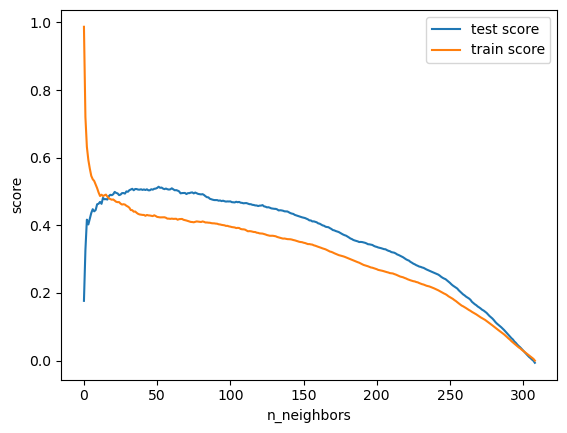

In [13]:
# 5. 모델 개선 : 적정 n_neighbors 찾기
max_n = len(X_train)
train_scores = []
test_scores = []
for n in range(1, max_n+1):
    knn = KNeighborsRegressor(n_neighbors=n)    
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test, y_test))

# score 최대값 찾기
print('최대 test score :', max(test_scores))
k = test_scores.index(max(test_scores))+1
print('해당 n_neighbors 값 :', k)

# 시각화
plt.plot(test_scores)
plt.plot(train_scores)
plt.legend(['test score', 'train score'])
plt.xlabel('n_neighbors')
plt.ylabel('score')
plt.show()

In [14]:
# 5-2. 확인
# 최대 score를 기록한 n_neighbor 값 사용
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('n_neighbors :', k)
print('test score:', knn.score(X_test, y_test))
print('-'*30)
# 1) R2
r2 = r2_score(y_test, y_pred)
print('R2 :', r2)
# 2) RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE :', rmse)
# 3) MAE
mae = mean_absolute_error(y_test, y_pred)
print('MAE :', mae)

n_neighbors : 52
test score: 0.5139764780942386
------------------------------
R2 : 0.5139764780942386
RMSE : 51.22210997960747
MAE : 41.95676691729323


In [15]:
# 6. 평가
print(f"""test score 값이 최대가 되도록 n_neighbors의 값을 조정할 때
test score : {knn.score(X_test, y_test):.4f}, R2 : {r2:.4f} 으로 나옴.
이는 조정하지 않았을 때보다 더 큰 값을 나타냄.""")

test score 값이 최대가 되도록 n_neighbors의 값을 조정할 때
test score : 0.5140, R2 : 0.5140 으로 나옴.
이는 조정하지 않았을 때보다 더 큰 값을 나타냄.


최적의 n_neighbors : 38
maximum test score : 0.3601161005853817


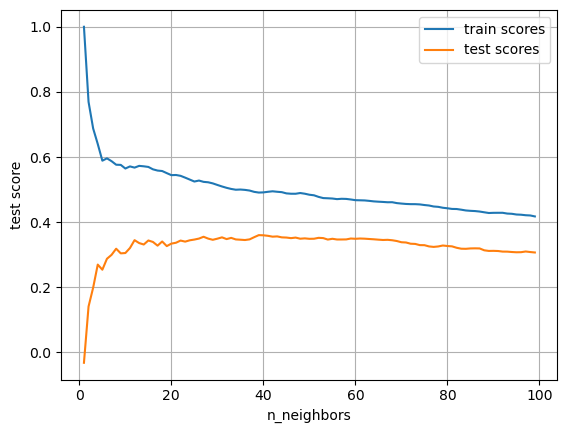

In [16]:
# 이상치를 제거했을 때
# : remove_feature, remove_target
X_train, X_test, y_train, y_test = train_test_split(remove_feature, remove_target, test_size=0.3, random_state=42)

# 5-1. 최적의 n_neighbors 찾기
train_scores, test_scores = [], []
for k in range(1, 100):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))

# 최적의 n_neighbors 찾기
k = test_scores.index(max(test_scores))
print(f'최적의 n_neighbors : {k}')
print('maximum test score :', max(test_scores))

# 그래프 그리기
plt.plot(range(1, 100), train_scores, label='train scores')
plt.plot(range(1, 100), test_scores, label='test scores')
plt.xlabel('n_neighbors')
plt.ylabel('test score')
plt.legend()
plt.grid()
plt.show()

In [17]:
# 이상치 제거 시 최대 score가 0.36으로 감소

In [18]:
# 주영: random_state 를 바꿔가며 가장 높은 점수를 찾기


In [19]:
# pipeline 실행
from sklearn.pipeline import make_pipeline


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Define the pipeline steps
pipeline_steps = [
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
]

# Create the pipeline
make_pipeline = Pipeline(pipeline_steps)

# Train the pipeline
make_pipeline.fit(X_train, y_train)

# Make predictions using the pipeline
predictions = make_pipeline.predict(X_test)
predictions

array([ 72.,  96., 275., 214., 140.,  88.,  69., 140.,  51., 248., 182.,
       101.,  96., 103.,  77.,  55., 232.,  55., 102., 150., 220., 220.,
        72., 150., 182.,  48., 155.,  91., 275., 140., 217.,  94.,  94.,
        71.,  42.,  91.,  47., 115.,  84., 202., 113., 200.,  89., 237.,
       131.,  72., 118.,  91., 101., 308.,  91.,  91., 150., 178., 259.,
       128.,  91., 275.,  65.,  96.,  91., 134., 137., 144., 155., 258.,
       101., 173., 118., 104.,  39., 182., 220., 116.,  65., 131., 129.,
       128., 101., 180., 248., 140., 214.,  87.,  51., 116.,  91., 131.,
       202., 230., 259., 182., 118., 178., 275., 128., 109., 128.,  96.,
       150.,  99.,  99.,  71., 263.,  90.,  48., 202.,  91., 230., 128.,
       258., 200., 103., 150., 220.,  77., 178.,  95., 113.,  91., 128.,
        63., 109., 185., 140.,  80., 128.,  89., 268.,  72., 128.])